In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("genes/combined-gene-on-off.csv")

df_off = pd.DataFrame(columns=['gene', 'celltype', 'off-period'])
for index, row in df.iterrows():
    gene = row['gene']
    celltype = row['celltype']
    # Extract off-period values from the string
    off_periods = [int(period) for period in re.findall(r'\d+', row['off-period'])]
    # Append each off-period to the new DataFrame
    for off_period in off_periods:
        if off_period >= 2:
            df_off = df_off.append({'gene': gene, 'celltype': celltype, 'off-period': off_period}, ignore_index=True)
df_off['off-period'] = df_off['off-period'].astype(int)
df_off_stats = df_off.groupby(['gene', 'celltype'])['off-period'].agg(['mean', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), 'count']).reset_index()
df_off_stats.columns = ['gene', 'celltype', 'off-period_mean', 'off-std', 'off-q25', 'off-q75', 'off-count']

df_off_stats['off-se'] = df_off_stats['off-std'] / np.sqrt(df_off_stats['off-count'])



df_on = pd.DataFrame(columns=['gene', 'celltype', 'off-period'])
for index, row in df.iterrows():
    gene = row['gene']
    celltype = row['celltype']
    # Extract off-period values from the string
    off_periods = [int(period) for period in re.findall(r'\d+', row['on-period'])]
    # Append each off-period to the new DataFrame
    for off_period in off_periods:
        if off_period >= 2:
            df_on = df_on.append({'gene': gene, 'celltype': celltype, 'off-period': off_period}, ignore_index=True)
df_on['off-period'] = df_on['off-period'].astype(int)
df_on_stats = df_on.groupby(['gene', 'celltype'])['off-period'].agg(['mean', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), 'count']).reset_index()
df_on_stats.columns = ['gene', 'celltype', 'on-period_mean', 'on-std', 'on-q25', 'on-q75', 'on-count']
df_on_stats['on-se'] = df_on_stats['on-std'] / np.sqrt(df_on_stats['on-count'])



df = pd.merge(df, df_off_stats, on=['gene', 'celltype'])
df = pd.merge(df, df_on_stats, on=['gene', 'celltype'])

df.shape

(83, 58)

In [3]:
df.head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,Sum of initiator effect,celltype,strand,H3K27me3_tss,cluster,gene_type,comment,off-period_mean,off-std,off-q25,off-q75,off-count,off-se,on-period_mean,on-std,on-q25,on-q75,on-count,on-se
0,LUZP1,"[213, 55, 11, 40]","[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,1.355976,HBEC,-,0.0,cluster0,simple,NaN,79.75,90.691326,32.75,94.5,4,45.345663,5.333333,2.886751,4.5,7.0,3,1.666667


In [4]:
df = df[['gene', 'celltype', 
         'off-mean', 'off-std', 'off-q25', 'off-q75', 'off-se','off-count',
         'on-mean', 'on-std', 'on-q25', 'on-q75', 'on-se','on-count']]
df_ESC_D0 = df[df["celltype"]=="H9D0"]
df_ESC_D3 = df[df["celltype"]=="H9D3"]
df_ESC_D0.shape, df_ESC_D3.shape

((16, 14), (26, 14))

In [5]:
df_ESC = pd.merge(df_ESC_D0, df_ESC_D3, on="gene", suffixes=("_ESC_D0", "_ESC_D3"))
df_ESC.shape

(11, 27)

In [6]:
df_ESC.head()

,gene,celltype_ESC_D0,off-mean_ESC_D0,off-std_ESC_D0,off-q25_ESC_D0,off-q75_ESC_D0,off-se_ESC_D0,off-count_ESC_D0,on-mean_ESC_D0,on-std_ESC_D0,on-q25_ESC_D0,on-q75_ESC_D0,on-se_ESC_D0,on-count_ESC_D0,celltype_ESC_D3,off-mean_ESC_D3,off-std_ESC_D3,off-q25_ESC_D3,off-q75_ESC_D3,off-se_ESC_D3,off-count_ESC_D3,on-mean_ESC_D3,on-std_ESC_D3,on-q25_ESC_D3,on-q75_ESC_D3,on-se_ESC_D3,on-count_ESC_D3
0,SON,H9D0,30.000000,47.898932,9.0,27.50,12.801528,14,22.461538,29.084977,10.00,19.00,8.066721,13,H9D3,21.000000,22.300972,9.5,19.50,8.428975,7,13.333333,12.894443,2.25,25.00,5.264134,6
1,EEF1D,H9D0,17.040816,24.462522,4.0,17.00,3.494646,49,19.775510,19.726532,5.00,28.00,2.818076,49,H9D3,22.300000,26.393979,6.5,23.25,5.901873,20,18.588235,12.041900,11.00,27.00,2.920590,17
2,IVNS1ABP,H9D0,51.875000,76.750872,13.5,46.25,27.135531,8,32.428571,15.794514,33.75,42.75,6.448083,6,H9D3,51.250000,22.306576,39.5,65.75,11.153288,4,5.333333,6.363961,5.25,9.75,4.500000,2
3,DIDO1,H9D0,26.000000,21.260292,11.0,38.00,8.035635,7,31.333333,64.524931,4.25,7.25,26.342193,6,H9D3,13.500000,10.726348,4.5,23.00,3.234116,11,12.500000,10.535654,4.50,14.50,3.041381,12
4,HNRNPC,H9D0,10.500000,13.634515,4.0,8.00,5.566267,6,43.400000,42.453504,21.00,35.00,18.985784,5,H9D3,11.209677,14.717841,4.5,12.50,1.916100,59,23.718750,27.916549,7.00,30.75,3.545405,62


In [7]:
cols = ['gene',
        'off-mean_ESC_D0', 'off-se_ESC_D0', 'off-count_ESC_D0',
        'off-mean_ESC_D3', 'off-se_ESC_D3', 'off-count_ESC_D3',
        'on-mean_ESC_D0', 'on-se_ESC_D0', 'on-count_ESC_D0',
        'on-mean_ESC_D3', 'on-se_ESC_D3', 'on-count_ESC_D3',
       ]
df_ESC[cols].to_csv("ESC-D0-D3-off-on-period-comparison.csv", index=False)

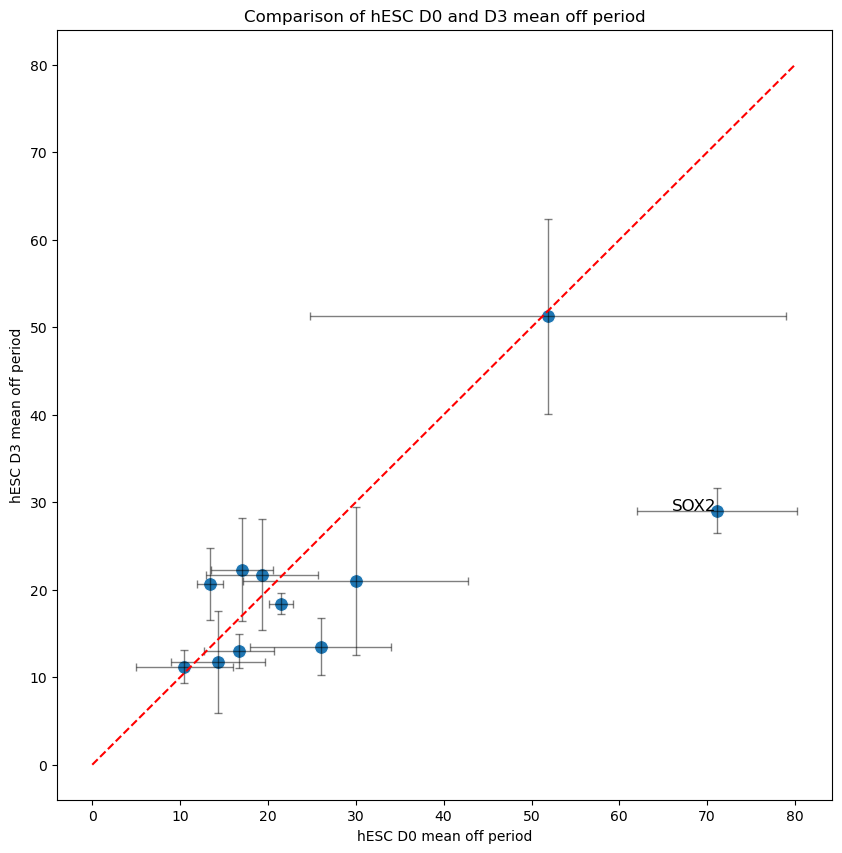

In [9]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x='off-mean_ESC_D0', y='off-mean_ESC_D3', data=df_ESC, s=100)
plt.errorbar(df_ESC['off-mean_ESC_D0'], df_ESC['off-mean_ESC_D3'],
             xerr=df_ESC['off-se_ESC_D0'], yerr=df_ESC['off-se_ESC_D3'],
             fmt='none', ecolor='black', alpha=0.5, capsize=3, elinewidth=1)


plt.title('Comparison of hESC D0 and D3 mean off period')
plt.xlabel('hESC D0 mean off period')
plt.ylabel('hESC D3 mean off period')

# Adding the diagonal line
max_val = max(df_ESC['off-mean_ESC_D0'].max(), df_ESC['off-mean_ESC_D3'].max())
min_val = min(df_ESC['off-mean_ESC_D0'].min(), df_ESC['off-mean_ESC_D3'].min())
plt.plot([0, 80], [0, 80], color='red', linestyle='--')

# Annotating the points with gene names
for i, row in df_ESC.iterrows():
    if row["gene"] in {"DISC1", "SOX2", "YWHAG"}:
        plt.text(row['off-mean_ESC_D0'], row['off-mean_ESC_D3'], row['gene'], fontsize=12, ha='right')

plt.savefig("figs/Comparison of ESC D0 and D3 mean off period.tif", format='tiff')
plt.show()

In [10]:
# plt.figure(figsize=(10, 10))
# sns.scatterplot(x='off-mean_ESC_D0', y='off-mean_ESC_D3', data=df_ESC, s=100)

# for i in range(len(df_ESC)):
#     plt.plot([df_ESC['off-q25_ESC_D0'][i], df_ESC['off-q75_ESC_D0'][i]],
#              [df_ESC['off-period_mean_ESC_D3'][i], df_ESC['off-period_mean_ESC_D3'][i]], color='black')
#     plt.plot([df_ESC['off-period_mean_ESC_D0'][i], df_ESC['off-period_mean_ESC_D0'][i]],
#              [df_ESC['off-q25_ESC_D3'][i], df_ESC['off-q75_ESC_D3'][i]], color='black')



# plt.title('Comparison of ESC D0 and D3 mean off period')
# plt.xlabel('ESC D0 mean off period')
# plt.ylabel('ESC D3 mean off period')


# plt.plot([0, 120], [0, 120], color='red', linestyle='--')

# # Annotating the points with gene names
# for i, row in df_ESC.iterrows():
#     if row["gene"] in {"DISC1", "SOX2", "YWHAG"}:
#         plt.text(row['off-mean_ESC_D0'], row['off-mean_ESC_D3'], row['gene'], fontsize=12, ha='right')

# plt.show()

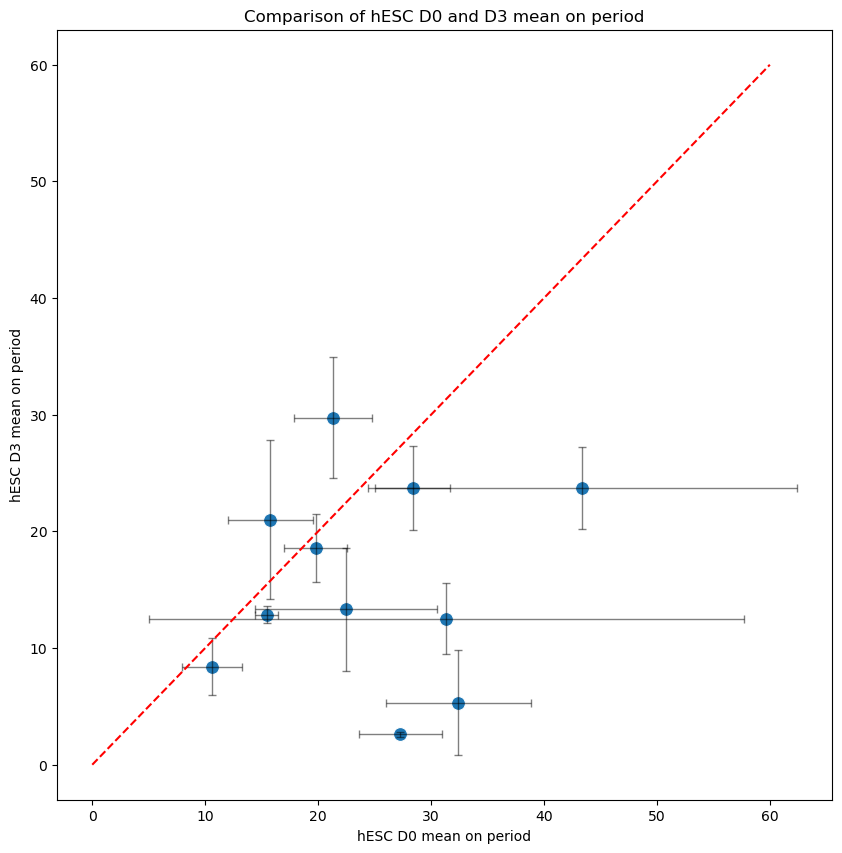

In [11]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x='on-mean_ESC_D0', y='on-mean_ESC_D3', data=df_ESC, s=100)
plt.errorbar(df_ESC['on-mean_ESC_D0'], df_ESC['on-mean_ESC_D3'],
             xerr=df_ESC['on-se_ESC_D0'], yerr=df_ESC['on-se_ESC_D3'],
             fmt='none', ecolor='black', alpha=0.5, capsize=3, elinewidth=1)


plt.title('Comparison of hESC D0 and D3 mean on period')
plt.xlabel('hESC D0 mean on period')
plt.ylabel('hESC D3 mean on period')

# Adding the diagonal line
max_val = max(df_ESC['on-mean_ESC_D0'].max(), df_ESC['on-mean_ESC_D3'].max())
min_val = min(df_ESC['on-mean_ESC_D0'].min(), df_ESC['on-mean_ESC_D3'].min())
plt.plot([0, 60], [0, 60], color='red', linestyle='--')

# Annotating the points with gene names
# for i, row in df_ESC.iterrows():
#     if row["gene"] in {"DISC1", "SOX2", "YWHAG"}:
#         plt.text(row['on-mean_ESC_D0'], row['on-mean_ESC_D3'], row['gene'], fontsize=12, ha='right')


plt.savefig("figs/Comparison of ESC D0 and D3 mean on period.tif", format='tiff')
plt.show()